In [1]:
'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

import esio
import esiodata as ed

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()

# Get median ice edge
import timeit
start_time = timeit.default_timer()
ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'/*.nc', concat_dim='time', autoclose=True) 
print( (timeit.default_timer() - start_time)/60 , " minutes.")
# https://github.com/dask/dask/issues/731

1217
0.9600843771001867  minutes.


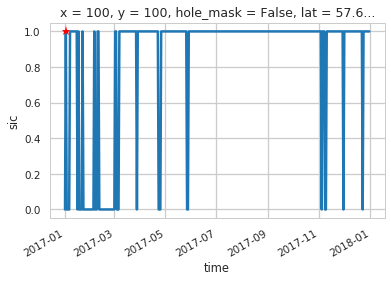

In [85]:
cy = ds_81.sic.sel(time=slice('2017-01-01','2017-12-31'))
oceanPres = cy[:,100,100]<0.15
oceanPres.plot()
IFD = np.argmax(oceanPres)
plt.plot(cy.time.isel(time=IFD.values), 1,'r*')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less
  return func(*args2)


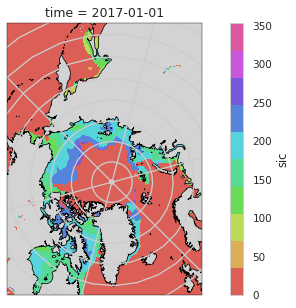

In [75]:
cy = ds_81.sic.sel(time=slice('2017-01-01','2017-12-31'))  # Binary snow no snow
IFD = (cy< 0.15).reduce(np.argmax, dim='time') # Find index of first ice free
IFD = IFD.where(cy.isel(time=0).notnull())

cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("hls", 10))
cmap_c.set_bad(color = 'lightgrey')

(f, ax1) = esio.polar_axis()
f.set_size_inches(10, 5)
p = IFD.plot(ax=ax1,  x='lon', y='lat', 
             cmap=cmap_c,
              transform=ccrs.PlateCarree());

# xr.apply_ufunc(np.argmax, cy, input_core_dims=[['time']], dask='allowed')

<xarray.DataArray 'time' (time: 365)>
array(['2017-01-01T00:00:00.000000000', '2017-01-02T00:00:00.000000000',
       '2017-01-03T00:00:00.000000000', ..., '2017-12-29T00:00:00.000000000',
       '2017-12-30T00:00:00.000000000', '2017-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 2017-01-02 2017-01-03 ...

In [76]:
def calc_IFD(x):
    ifd = (x<0.15).reduce(np.argmax, dim='time') # Find index of first ice free
    ifd = ifd.where(x.isel(time=0).notnull()) # Orig mask
    return ifd

In [77]:
da_IFD = ds_81.sic.groupby('time.year').apply(calc_IFD)

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less
  return func(*args2)


In [80]:
cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("hls", 20))
cmap_c.set_bad(color = 'lightgrey')

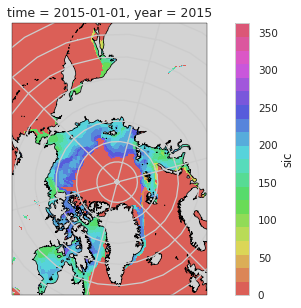

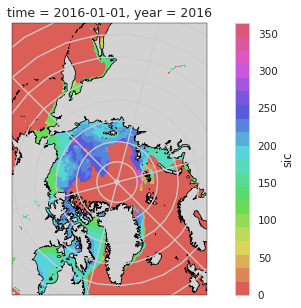

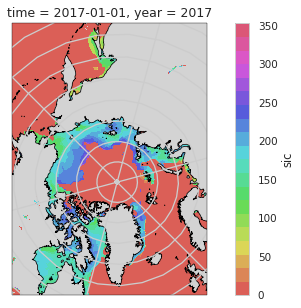

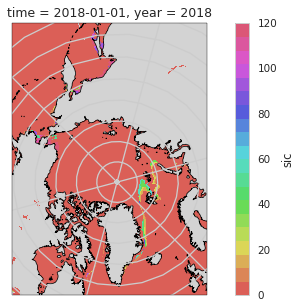

In [81]:
for y in da_IFD.year:
    (f, ax1) = esio.polar_axis()
    f.set_size_inches(10, 5)
    p = da_IFD.sel(year=y).plot(ax=ax1,  x='lon', y='lat', 
                 cmap=cmap_c,
                  transform=ccrs.PlateCarree());

In [82]:
dir_out = os.path.join(E.obs_dir, 'NSIDC_0081', 'agg_nc')
if not os.path.exists(dir_out):
    os.makedirs(dir_out)

In [83]:
da_IFD.to_netcdf(os.path.join(dir_out, 'IFD_FFD.nc'))

In [ ]:
da_IFD = None